In [4]:
%pip install --user pandas scipy numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import collections
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import gamma
from scipy.stats import chi2
from scipy.stats import kstest
import glob
import bz2
import os

#### Data preparation and distribution overview

In [6]:
# Extract the leading digit from a string
def get_leading_digit(s):
    return int(s[0])

# Convert a string to a number; return None if conversion fails
def convert_to_number(s):
    try:
        return float(s)
    except ValueError:
        return None

# List to store numbers
numbers = []

# Counter for leading digits
leading_digits = collections.Counter()

# Retrieve all .trans files, change if needed
filenames = glob.glob('/mnt/data/exomol/exomol3_data/TiO/49Ti-16O/Toto/*.trans.bz2')
filenames = sorted(filenames)

# ## For sample input
# # get current repository
# current_directory = os.getcwd()
# filenames = glob.glob(os.path.join(current_directory, '*.trans.bz2'))

# Process each file
for filename in filenames:

    # Open the file
    with bz2.open(filename, 'r') as file:

        # loop over the lines in the file
        for line in file:
            # Decode the line to a string
            line = line.decode('utf-8')    

            # Split the line on spaces (or appropriate delimiter)
            data = line.strip().split()

            # Extract the leading digit from the third column and update the counter
            leading_digits.update([get_leading_digit(data[2])])

            # Convert the third column to a number and add it to the list
            number = convert_to_number(data[2])
            if number is not None:
                numbers.append(number)

# Display data overview and leading digit frequencies

observed_frequencies = dict(sorted(leading_digits.items())) # Count the frequency of each leading digit

total_count = sum(leading_digits.values()) # Calculate the total count of leading digits

numbers_series = pd.Series(numbers) # Convert the list to a pandas Series

print('49Ti_16O Data Overview: ', '\n', numbers_series.describe())
print('first digits frequencies: ', observed_frequencies)

49Ti_16O Data Overview:  
 count    2.401000e+03
mean     1.016288e-27
std      1.261277e-26
min      2.281900e-71
25%      2.485700e-39
50%      2.744800e-33
75%      1.004600e-29
max      2.695000e-25
dtype: float64
first digits frequencies:  {1: 642, 2: 477, 3: 294, 4: 247, 5: 165, 6: 194, 7: 134, 8: 138, 9: 110}


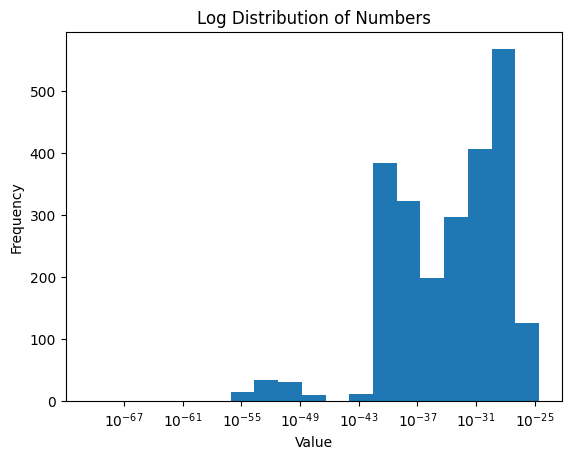

In [7]:
# To visualise the distribution of data on a logarithmic scale,
plt.hist(numbers, bins=np.logspace(np.log10(min(numbers)), np.log10(max(numbers)), 20))
plt.xscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log Distribution of Numbers')
plt.show()

##### Chi-square test 

In [8]:
## Write codes for the Chi-square test from scratch. it generates the same answer as applying the function from the package.

# Calculate expected frequencies under uniform distribution and Benford's Law
expected_frequencies_uni = {i: total_count / 9 for i in range(1, 10)}
expected_frequencies_ben = {i: total_count * math.log10(1 + 1/i) for i in range(1, 10)}

# Custom chi-square statistic function
def chi_square_statistic(observed, expected):
    return sum([(o - e)**2 / e for o, e in zip(observed, expected)])

# Use the custom chi-square statistic function
chi2_stat_uni = chi_square_statistic(list(observed_frequencies.values()), list(expected_frequencies_uni.values()))
chi2_stat_ben = chi_square_statistic(list(observed_frequencies.values()), list(expected_frequencies_ben.values()))

# Print chi-square values
print("Chi-square statistic for Uniform distribution:", chi2_stat_uni)
print("Chi-square statistic for Benford's Law:", chi2_stat_ben)

# Chi-square PDF function
def chi2_pdf(x, df):
    return (1 / (2 ** (df / 2) * gamma(df / 2))) * x ** (df / 2 - 1) * np.exp(-x / 2)

# Compute p-value using numerical integration
def chi2_p_value_from_scratch(chi2_stat, df):
    # Integrate from chi2_stat to infinity
    return quad(chi2_pdf, chi2_stat, np.inf, args=(df))[0]

# Calculate p-values
df = 9 - 1
p_value_uni_scratch = chi2_p_value_from_scratch(chi2_stat_uni, df)
p_value_ben_scratch = chi2_p_value_from_scratch(chi2_stat_ben, df)
print("P-value from scratch for Uniform distribution:", p_value_uni_scratch)
print("P-value from scratch for Benford's Law:", p_value_ben_scratch)

# Calculate critical value for the comparison of Chi-square statistic
p_threshold = 0.001
critical_value = chi2.ppf(1 - p_threshold, df)
print("Critical_value in this task: ",critical_value)

Chi-square statistic for Uniform distribution: 976.7138692211581
Chi-square statistic for Benford's Law: 29.250655555704896
P-value from scratch for Uniform distribution: 1.5849172594741218e-205
P-value from scratch for Benford's Law: 0.0002865271207239444
Critical_value in this task:  26.12448155837614


#### Plot bar chat comparing the first digits of the observed (dataset) with the expected (uniform distribution and Benford's Law)

In [9]:
# Perform a chi-square test by using function in library and compared with the calculation we built from the ground
chi2_uni, p_uni = chisquare(list(observed_frequencies.values()), list(expected_frequencies_uni.values()))
chi2_ben, p_ben = chisquare(list(observed_frequencies.values()), list(expected_frequencies_ben.values()))


Chi-square statistic for uniform distribution expected frequency: 976.7138692211579
P-value for uniform distribution expected frequency: 1.584928001099399e-205


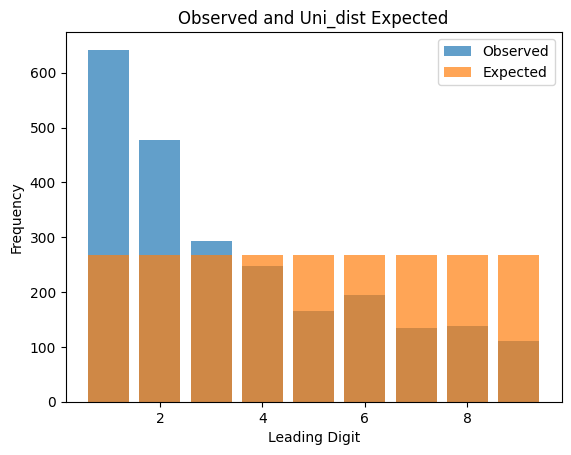

In [10]:
# Print the results for uniform distribution expected frequency
print(f"Chi-square statistic for uniform distribution expected frequency: {chi2_uni}")
print(f"P-value for uniform distribution expected frequency: {p_uni}")

# Create a bar plot for uniform distribution expected frequency
plt.title('Observed and Uni_dist Expected')
plt.bar(range(1, 10), [observed_frequencies[i] for i in range(1, 10)], alpha=0.7, label='Observed')
plt.bar(range(1, 10), [expected_frequencies_uni[i] for i in range(1, 10)], alpha=0.7, label='Expected')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Chi-square statistic for Benford's Law expected frequency: 29.250655555704896
P-value for Benford's Law expected frequency: 0.00028652712072345046


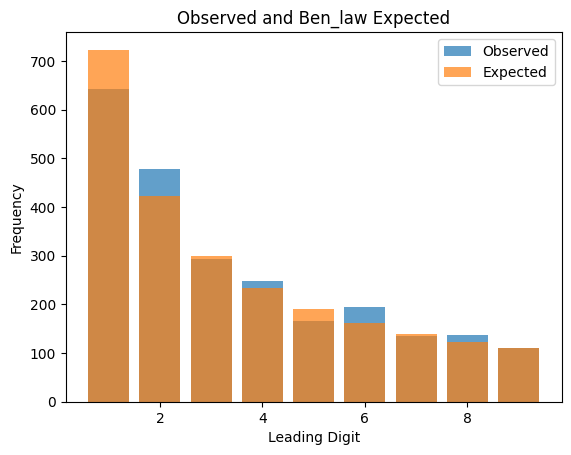

In [11]:
# Print the results for Benford's Law
print(f"Chi-square statistic for Benford's Law expected frequency: {chi2_ben}")
print(f"P-value for Benford's Law expected frequency: {p_ben}")

# Create a bar plot for Benford's Law
plt.title('Observed and Ben_law Expected')
plt.bar(range(1, 10), [observed_frequencies[i] for i in range(1, 10)], alpha=0.7, label='Observed')
plt.bar(range(1, 10), [expected_frequencies_ben[i] for i in range(1, 10)], alpha=0.7, label='Expected')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### bar plot to compare the observed with the expected both in the normalised ratio

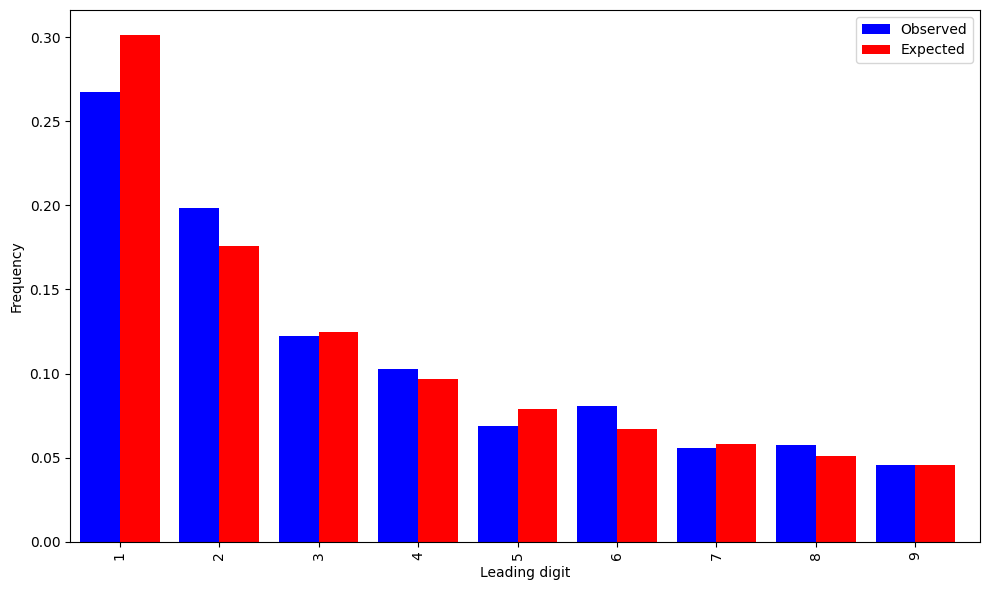

In [12]:
# Convert the frequencies to ratios
observed_ratios = {k: v / total_count for k, v in observed_frequencies.items()}

# Calculate expected frequencies according to Benford's law
expected_frequencies = {i: math.log10(1 + 1 / i) for i in range(1, 10)}

# Create a dataframe from the observed and expected ratios
df = pd.DataFrame({'observed': observed_ratios, 'expected': expected_frequencies})

# Create a bar plot to compare the observed with the expected both in the normalised ratio
fig, ax = plt.subplots(figsize=(10, 6))
df['observed'].plot(kind='bar', color='blue', ax=ax, width=0.4, position=1, label='Observed')
df['expected'].plot(kind='bar', color='red', ax=ax, width=0.4, position=0, label='Expected')
ax.set_xlabel('Leading digit')
ax.set_ylabel('Frequency')
ax.set_xlim(left=-0.5)  
plt.tight_layout() 
plt.legend()               
plt.show()

#### MAD tests

In [13]:
# Calculate the absolute deviation between the observed and expected ratios
df['absolute_deviation'] = abs(df['observed'] - df['expected'])

# Print the absolute_difference
print(df['absolute_deviation'])

# Print Max and Min absolute_deviation
max_absolute_difference = df['absolute_deviation'].max()
min_absolute_difference = df['absolute_deviation'].min()
print(f'Max absolute_deviation: {max_absolute_difference}')
print(f'Min absolute_deviation: {min_absolute_difference}')

# Calculate and print the mean absolute_deviation
mean_absolute_difference = df['absolute_deviation'].mean()
print(f'Mean absolute_deviation: {mean_absolute_difference}')

# Calculate and print Correlation between Observed and Expected Frequencies
correlation = df['observed'].corr(df['expected'])
print(f'Correlation: {correlation}')


1    0.033641
2    0.022576
3    0.002490
4    0.005964
5    0.010460
6    0.013853
7    0.002182
8    0.006324
9    0.000057
Name: absolute_deviation, dtype: float64
Max absolute_deviation: 0.03364140757568468
Min absolute_deviation: 5.675350429778375e-05
Mean absolute_deviation: 0.010838424974734603
Correlation: 0.983772606411448


#### Z-statistics test

Z-statistic for 1: -3.5936525316010903
Z-statistic for 2: 2.904249403966181
Z-statistic for 3: -0.3689650759497816
Z-statistic for 4: 0.9877989314046212
Z-statistic for 5: -1.8981238070048232
Z-statistic for 6: 2.715926296259378
Z-statistic for 7: -0.45741812487044736
Z-statistic for 8: 1.4064486392174753
Z-statistic for 9: 0.013308474704611693


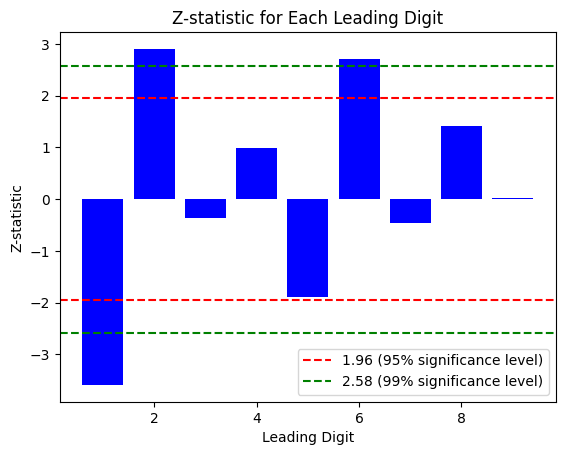

In [14]:
# Calculate the Z-statistic (standard deviations) for each leading digit
z_statistics = [(observed_ratios[i] - expected_frequencies[i]) / 
                np.sqrt(expected_frequencies[i] * (1 - expected_frequencies[i]) / total_count) 
                for i in range(1, 10)]

for i, z in enumerate(z_statistics, start=1):
    print(f"Z-statistic for {i}: {z}")

# visulised the z-statistic
plt.bar(range(1,10), z_statistics, color='blue')
plt.axhline(y=1.96, color='r', linestyle='--', label='1.96 (95% significance level)')
plt.axhline(y=-1.96, color='r', linestyle='--')
plt.axhline(y=2.58, color='g', linestyle='--', label='2.58 (99% significance level)')
plt.axhline(y=-2.58, color='g', linestyle='--')
plt.xlabel('Leading Digit')
plt.ylabel('Z-statistic')
plt.title('Z-statistic for Each Leading Digit')
plt.legend()
plt.show()
